In [1]:
#import library or packages
import torch
import torchvision
from torch.utils.data import DataLoader
import cv2
from nets.resnet import resnet34
from tqdm import tqdm
import torch.nn as nn
import os
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random
import torch.optim as optim

Number of training samples: 196
Number of validation samples: 92

Random sample training data:
Sample 1:
 - Image shape: torch.Size([3, 224, 224])
 - Label: 2
Sample 2:
 - Image shape: torch.Size([3, 224, 224])
 - Label: 2
Sample 3:
 - Image shape: torch.Size([3, 224, 224])
 - Label: 2
Sample 4:
 - Image shape: torch.Size([3, 224, 224])
 - Label: 1
Sample 5:
 - Image shape: torch.Size([3, 224, 224])
 - Label: 0

Random sample validation data:
Sample 1:
 - Image shape: torch.Size([3, 224, 224])
 - Label: 3
Sample 2:
 - Image shape: torch.Size([3, 224, 224])
 - Label: 1
Sample 3:
 - Image shape: torch.Size([3, 224, 224])
 - Label: 2
Sample 4:
 - Image shape: torch.Size([3, 224, 224])
 - Label: 3
Sample 5:
 - Image shape: torch.Size([3, 224, 224])
 - Label: 3


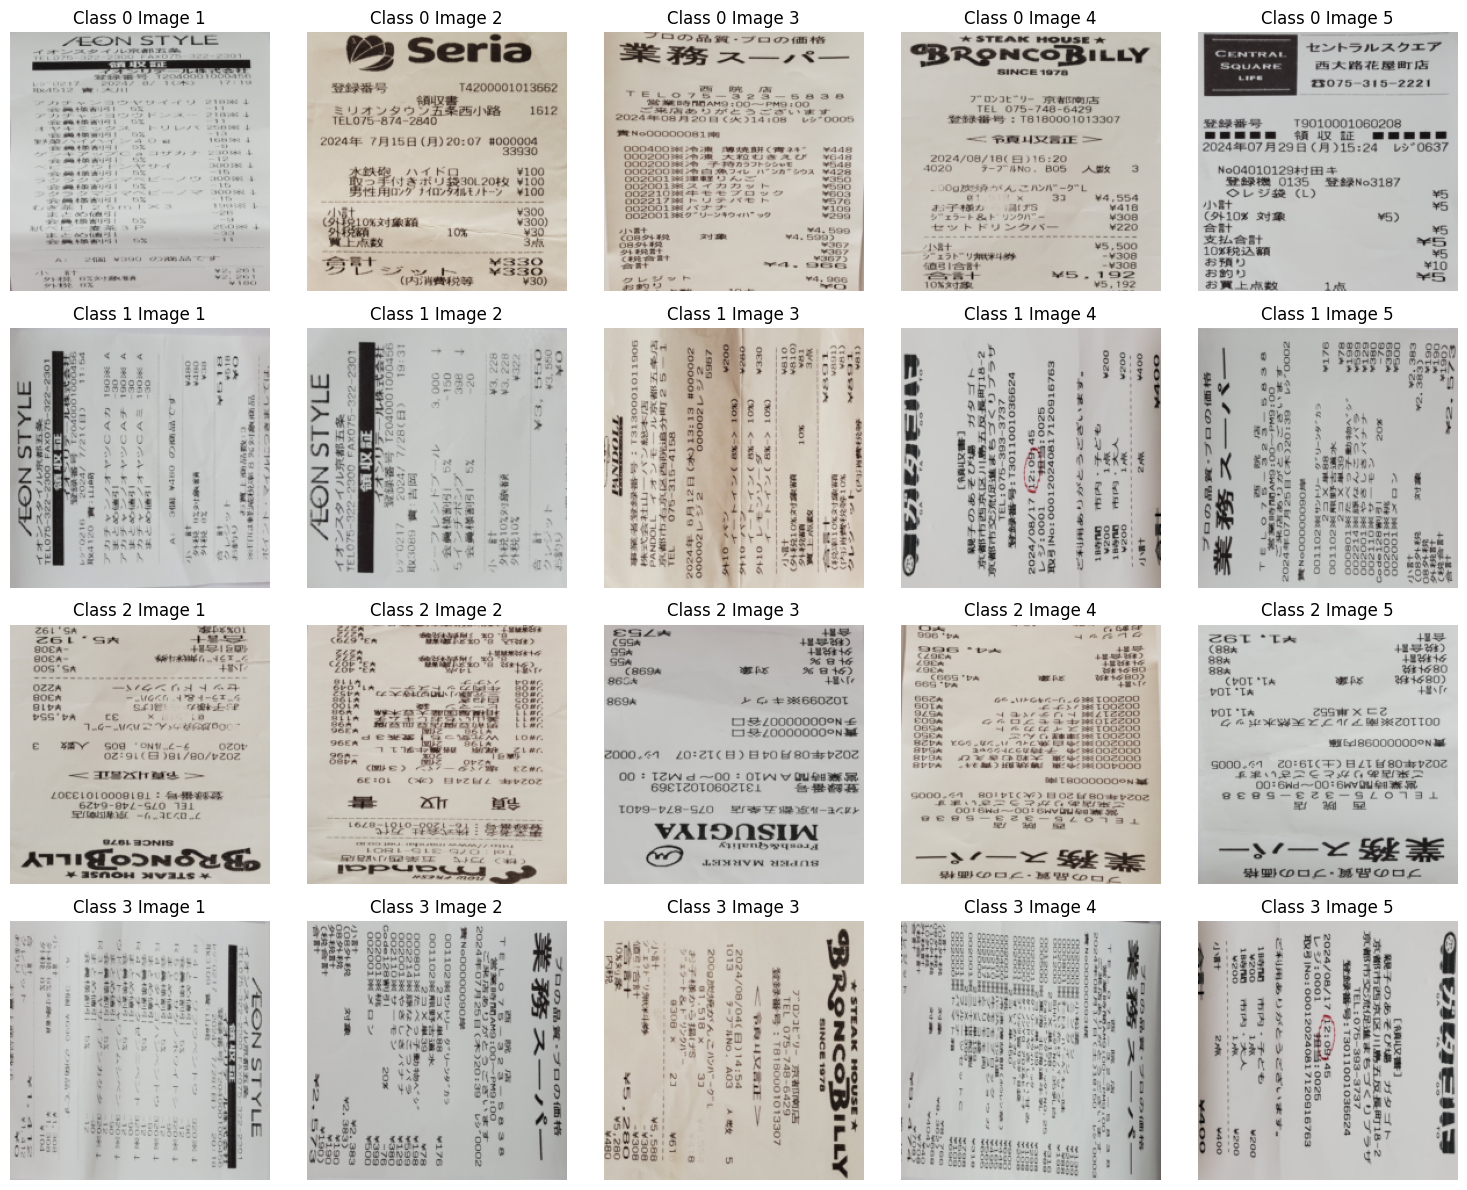

In [2]:
# data load, transdorm and pre plot
from datamodule.dataloader import RotatedReceiptDataset, get_data_transforms
from plotmodule.plot_utils import plot_samples_from_each_class 

# Now you can call the function with any image size
data_transforms = get_data_transforms(image_size=224)

#load the data and Assuming data_transforms is already defined
train_dataset = RotatedReceiptDataset(root_dir='./data/Receipt_data/train', transform=data_transforms['train'])
test_dataset = RotatedReceiptDataset(root_dir='./data/Receipt_data/val', transform=data_transforms['val'])

# Print the length (number of samples) in the dataset
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(test_dataset)}")

# Function to print the shape and label of randomly selected images
def print_random_samples(dataset, num_samples=5):
    # Randomly select indices from the dataset
    random_indices = random.sample(range(len(dataset)), num_samples)

    # Print the details of the randomly selected images
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]
        print(f"Sample {i + 1}:")
        print(f" - Image shape: {image.shape}")  # Tensor shape: (Channels, Height, Width)
        print(f" - Label: {label}")

# Randomly print 5 images from the training dataset
print("\nRandom sample training data:")
print_random_samples(train_dataset, num_samples=5)

# Randomly print 5 images from the validation dataset
print("\nRandom sample validation data:")
print_random_samples(test_dataset, num_samples=5)   

# Call the function to plot 5 random images from each of the 4 classes in the training dataset
plot_samples_from_each_class(train_dataset, num_samples=5)

In [3]:
from debug_images.debug_utils import save_first_batch_images  # Import the debugging function

# --------------------------------------------------------------------
# Utility Functions
# --------------------------------------------------------------------

# Function to get the current learning rate 
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# --------------------------------------------------------------------
# Training and Validation Loop (Main Function)
# --------------------------------------------------------------------

def fit_one_epoch(net, softmaxloss, epoch, epoch_size, epoch_size_val, gen, gen_test, Epoch, cuda, save_first_batch_images_flag=False):
    """
    Trains and validates the model for one epoch.
    
    Args:
        net: Neural network model.
        softmaxloss: Loss function, typically CrossEntropyLoss.
        epoch: Current epoch number.
        epoch_size: Number of batches in training dataset.
        epoch_size_val: Number of batches in validation dataset.
        gen: Training data DataLoader.
        gen_test: Validation data DataLoader.
        Epoch: Total number of epochs.
        cuda: Whether to use GPU for training.
        save_first_batch_images_flag: Flag to save images from the first batch for debugging.
    """
    # ----------------------------------------------------------------
    # Training Phase
    # ----------------------------------------------------------------
    print('\nStart train')
    net.train()  # Set the model to training mode
    total_loss = 0

    with tqdm(total=epoch_size, desc=f'Epoch {epoch + 1}/{Epoch}', postfix=dict, mininterval=0.3) as pbar:
        for iteration, batch in enumerate(gen):
            images, targets = batch[0], batch[1]

            # Move data to GPU if available
            if cuda:
                images = images.cuda()
                targets = targets.cuda()

            # Optionally save the first batch images for debugging
            if save_first_batch_images_flag:
                save_first_batch_images(epoch, iteration, images, targets)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass outputs,_ = net(images)
            outputs= net(images)

            # Handle tuple outputs (if model returns multiple outputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            # Compute loss
            loss = softmaxloss(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update total loss
            total_loss += loss.item()

            # Update progress bar with current total loss and learning rate
            pbar.set_postfix(**{
                'total_loss': float(total_loss / (iteration + 1)),
                'lr': get_lr(optimizer)
            })
            pbar.update(1)

    # ----------------------------------------------------------------
    # Validation Phase
    # ----------------------------------------------------------------
    print('\nStart test')
    net.eval()  # Set the model to evaluation mode
    test_correct = 0  # Variable to track number of correct predictions

    with torch.no_grad():  # Disable gradient computation for validation
        with tqdm(total=epoch_size_val, desc=f'Epoch {epoch + 1}/{Epoch}', postfix=dict, mininterval=0.3) as pbar:
            for iteration, batch in enumerate(gen_test):
                images, targets = batch[0], batch[1]

                # Move data to GPU if available
                if cuda:
                    images = images.cuda()
                    targets = targets.cuda()

                # Forward pass
                outputs = net(images)

                # Handle tuple outputs (if model returns multiple outputs)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]

                # Get the predicted class (highest score)
                _, predicted = torch.max(outputs, 1)

                # Count number of correct predictions
                test_correct += torch.sum(predicted == targets).item()

                # Update progress bar with test accuracy
                pbar.set_postfix(**{
                    'test AP': float(100 * test_correct / len(gen_test.dataset))
                })
                pbar.update(1)

    # ----------------------------------------------------------------
    # Save Model After Epoch
    # ----------------------------------------------------------------
    torch.save(net.state_dict(), f'logs/Epoch{epoch + 1}-Total_Loss{round(total_loss / epoch_size, 4)}.pth')


# Main script to run training and validation
if __name__ == '__main__':
    # ----------------------------------------------------------------
    # System Setup
    # ----------------------------------------------------------------
    # Automatically detect if CUDA (GPU) is available
    cuda = torch.cuda.is_available()

    # Define training configuration variables
    pre_train = False      # Whether to load a pretrained model
    CosineLR = False       # Whether to use Cosine Annealing LR scheduler
    lr = 1e-3              # Learning rate
    Batch_size = 8         # Batch size for training
    Init_Epoch = 0         # Initial epoch (usually 0)
    Fin_Epoch = 100         # Final epoch (number of epochs to train)

    # ----------------------------------------------------------------
    # Model Creation
    # ----------------------------------------------------------------
    # Create the model (example using ResNet34)
    model = resnet34(num_classes=4)  # Assuming 4 classes

    # Load the pretrained model if needed
    if pre_train:
        model_path = 'logs/resnet50-mnist.pth'  # Path to the pre-trained model
        if cuda:
            model.load_state_dict(torch.load(model_path))
        else:
            model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

    # Set the device (either GPU or CPU)
    device = torch.device('cuda' if cuda else 'cpu')
    model = model.to(device)

    # ----------------------------------------------------------------
    # Data Loading
    # ----------------------------------------------------------------
    # Assuming `train_dataset` and `test_dataset` are already defined elsewhere
    gen = DataLoader(dataset=train_dataset, batch_size=Batch_size, shuffle=True, num_workers=0)
    gen_test = DataLoader(dataset=test_dataset, batch_size=Batch_size // 2, shuffle=True, num_workers=0)

    epoch_size = len(gen)         # Number of training batches per epoch
    epoch_size_val = len(gen_test)  # Number of validation batches per epoch

    # ----------------------------------------------------------------
    # Loss Function and Optimizer
    # ----------------------------------------------------------------
    # Define the loss function (CrossEntropyLoss for classification)
    softmax_loss = torch.nn.CrossEntropyLoss()

    # Define the optimizer (Adam optimizer in this case)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # ----------------------------------------------------------------
    # Learning Rate Scheduler
    # ----------------------------------------------------------------
    # Choose the learning rate scheduler
    if CosineLR:
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-10)
    else:
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.92)

    # ----------------------------------------------------------------
    # Training Loop
    # ----------------------------------------------------------------
    # Loop over the range of epochs
    for epoch in range(Init_Epoch, Fin_Epoch):
        # Train and validate for one epoch
        fit_one_epoch(net=model, 
                      softmaxloss=softmax_loss, 
                      epoch=epoch, 
                      epoch_size=epoch_size,
                      epoch_size_val=epoch_size_val, 
                      gen=gen, 
                      gen_test=gen_test, 
                      Epoch=Fin_Epoch, 
                      cuda=cuda)
        
        # Step the learning rate scheduler
        lr_scheduler.step()




Start train


Epoch 1/100: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it, lr=0.001, total_loss=0.911]



Start test


Epoch 1/100: 100%|██████████| 23/23 [00:06<00:00,  3.55it/s, test AP=25]  



Start train


Epoch 2/100: 100%|██████████| 25/25 [00:30<00:00,  1.21s/it, lr=0.00092, total_loss=0.337]



Start test


Epoch 2/100: 100%|██████████| 23/23 [00:06<00:00,  3.49it/s, test AP=84.8]



Start train


Epoch 3/100: 100%|██████████| 25/25 [00:30<00:00,  1.21s/it, lr=0.000846, total_loss=0.389]



Start test


Epoch 3/100: 100%|██████████| 23/23 [00:06<00:00,  3.55it/s, test AP=96.7]



Start train


Epoch 4/100: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it, lr=0.000779, total_loss=0.117] 



Start test


Epoch 4/100: 100%|██████████| 23/23 [00:06<00:00,  3.46it/s, test AP=98.9]



Start train


Epoch 5/100: 100%|██████████| 25/25 [00:29<00:00,  1.16s/it, lr=0.000716, total_loss=0.0541]



Start test


Epoch 5/100: 100%|██████████| 23/23 [00:06<00:00,  3.57it/s, test AP=97.8]



Start train


Epoch 6/100: 100%|██████████| 25/25 [00:34<00:00,  1.37s/it, lr=0.000659, total_loss=0.0872]



Start test


Epoch 6/100: 100%|██████████| 23/23 [00:06<00:00,  3.55it/s, test AP=96.7]



Start train


Epoch 7/100: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it, lr=0.000606, total_loss=0.0437]



Start test


Epoch 7/100: 100%|██████████| 23/23 [00:07<00:00,  3.16it/s, test AP=97.8]



Start train


Epoch 8/100: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it, lr=0.000558, total_loss=0.243]



Start test


Epoch 8/100: 100%|██████████| 23/23 [00:06<00:00,  3.61it/s, test AP=93.5]



Start train


Epoch 9/100: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it, lr=0.000513, total_loss=0.0674]



Start test


Epoch 9/100: 100%|██████████| 23/23 [00:06<00:00,  3.48it/s, test AP=97.8]



Start train


Epoch 10/100: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it, lr=0.000472, total_loss=0.0347]



Start test


Epoch 10/100: 100%|██████████| 23/23 [00:06<00:00,  3.44it/s, test AP=97.8]



Start train


Epoch 11/100: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it, lr=0.000434, total_loss=0.0873]



Start test


Epoch 11/100: 100%|██████████| 23/23 [00:06<00:00,  3.53it/s, test AP=98.9]



Start train


Epoch 12/100: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it, lr=0.0004, total_loss=0.0356]



Start test


Epoch 12/100: 100%|██████████| 23/23 [00:06<00:00,  3.61it/s, test AP=100] 



Start train


Epoch 13/100: 100%|██████████| 25/25 [00:29<00:00,  1.18s/it, lr=0.000368, total_loss=0.0599] 



Start test


Epoch 13/100: 100%|██████████| 23/23 [00:06<00:00,  3.54it/s, test AP=100] 



Start train


Epoch 14/100: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it, lr=0.000338, total_loss=0.0987]



Start test


Epoch 14/100: 100%|██████████| 23/23 [00:06<00:00,  3.50it/s, test AP=100] 



Start train


Epoch 15/100: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it, lr=0.000311, total_loss=0.136] 



Start test


Epoch 15/100: 100%|██████████| 23/23 [00:06<00:00,  3.57it/s, test AP=98.9]



Start train


Epoch 16/100: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it, lr=0.000286, total_loss=0.0578]



Start test


Epoch 16/100: 100%|██████████| 23/23 [00:06<00:00,  3.62it/s, test AP=98.9]



Start train


Epoch 17/100: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it, lr=0.000263, total_loss=0.0408]



Start test


Epoch 17/100: 100%|██████████| 23/23 [00:06<00:00,  3.45it/s, test AP=98.9]



Start train


Epoch 18/100: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it, lr=0.000242, total_loss=0.0114] 



Start test


Epoch 18/100: 100%|██████████| 23/23 [00:07<00:00,  2.90it/s, test AP=98.9]



Start train


Epoch 19/100: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it, lr=0.000223, total_loss=0.069] 



Start test


Epoch 19/100: 100%|██████████| 23/23 [00:06<00:00,  3.50it/s, test AP=98.9]



Start train


Epoch 20/100: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it, lr=0.000205, total_loss=0.0265] 



Start test


Epoch 20/100: 100%|██████████| 23/23 [00:06<00:00,  3.59it/s, test AP=98.9]



Start train


Epoch 21/100: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it, lr=0.000189, total_loss=0.0225] 



Start test


Epoch 21/100: 100%|██████████| 23/23 [00:08<00:00,  2.80it/s, test AP=98.9]



Start train


Epoch 22/100: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it, lr=0.000174, total_loss=0.0109] 



Start test


Epoch 22/100: 100%|██████████| 23/23 [00:07<00:00,  3.03it/s, test AP=98.9]



Start train


Epoch 23/100: 100%|██████████| 25/25 [00:35<00:00,  1.40s/it, lr=0.00016, total_loss=0.00411]



Start test


Epoch 23/100: 100%|██████████| 23/23 [00:07<00:00,  3.07it/s, test AP=98.9]



Start train


Epoch 24/100: 100%|██████████| 25/25 [00:43<00:00,  1.74s/it, lr=0.000147, total_loss=0.0145] 



Start test


Epoch 24/100: 100%|██████████| 23/23 [00:06<00:00,  3.35it/s, test AP=98.9]



Start train


Epoch 25/100: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it, lr=0.000135, total_loss=0.00937]



Start test


Epoch 25/100: 100%|██████████| 23/23 [00:06<00:00,  3.41it/s, test AP=98.9]



Start train


Epoch 26/100: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it, lr=0.000124, total_loss=0.00519]



Start test


Epoch 26/100: 100%|██████████| 23/23 [00:06<00:00,  3.40it/s, test AP=98.9]



Start train


Epoch 27/100: 100%|██████████| 25/25 [00:33<00:00,  1.32s/it, lr=0.000114, total_loss=0.00678]



Start test


Epoch 27/100: 100%|██████████| 23/23 [00:06<00:00,  3.66it/s, test AP=98.9]



Start train


Epoch 28/100: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it, lr=0.000105, total_loss=0.00514]



Start test


Epoch 28/100: 100%|██████████| 23/23 [00:06<00:00,  3.46it/s, test AP=98.9]



Start train


Epoch 29/100: 100%|██████████| 25/25 [00:33<00:00,  1.33s/it, lr=9.68e-5, total_loss=0.00399]



Start test


Epoch 29/100: 100%|██████████| 23/23 [00:06<00:00,  3.66it/s, test AP=98.9]



Start train


Epoch 30/100: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it, lr=8.91e-5, total_loss=0.00315]



Start test


Epoch 30/100: 100%|██████████| 23/23 [00:06<00:00,  3.57it/s, test AP=98.9]



Start train


Epoch 31/100: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it, lr=8.2e-5, total_loss=0.00276]



Start test


Epoch 31/100: 100%|██████████| 23/23 [00:06<00:00,  3.61it/s, test AP=98.9]



Start train


Epoch 32/100: 100%|██████████| 25/25 [00:37<00:00,  1.50s/it, lr=7.54e-5, total_loss=0.00259]



Start test


Epoch 32/100: 100%|██████████| 23/23 [00:07<00:00,  2.97it/s, test AP=98.9]



Start train


Epoch 33/100: 100%|██████████| 25/25 [00:59<00:00,  2.40s/it, lr=6.94e-5, total_loss=0.00201]



Start test


Epoch 33/100: 100%|██████████| 23/23 [00:07<00:00,  3.00it/s, test AP=98.9]



Start train


Epoch 34/100: 100%|██████████| 25/25 [00:39<00:00,  1.57s/it, lr=6.38e-5, total_loss=0.00322]



Start test


Epoch 34/100: 100%|██████████| 23/23 [00:08<00:00,  2.86it/s, test AP=98.9]



Start train


Epoch 35/100: 100%|██████████| 25/25 [00:55<00:00,  2.21s/it, lr=5.87e-5, total_loss=0.00365]



Start test


Epoch 35/100: 100%|██████████| 23/23 [00:19<00:00,  1.18it/s, test AP=98.9]



Start train


Epoch 36/100: 100%|██████████| 25/25 [01:30<00:00,  3.60s/it, lr=5.4e-5, total_loss=0.00728]



Start test


Epoch 36/100: 100%|██████████| 23/23 [00:16<00:00,  1.42it/s, test AP=98.9]



Start train


Epoch 37/100: 100%|██████████| 25/25 [01:56<00:00,  4.67s/it, lr=4.97e-5, total_loss=0.00117] 



Start test


Epoch 37/100: 100%|██████████| 23/23 [00:10<00:00,  2.19it/s, test AP=98.9]



Start train


Epoch 38/100: 100%|██████████| 25/25 [00:59<00:00,  2.40s/it, lr=4.57e-5, total_loss=0.00356]



Start test


Epoch 38/100: 100%|██████████| 23/23 [00:09<00:00,  2.39it/s, test AP=98.9]



Start train


Epoch 39/100: 100%|██████████| 25/25 [00:51<00:00,  2.08s/it, lr=4.21e-5, total_loss=0.00262] 



Start test


Epoch 39/100: 100%|██████████| 23/23 [00:10<00:00,  2.28it/s, test AP=98.9]



Start train


Epoch 40/100: 100%|██████████| 25/25 [00:54<00:00,  2.18s/it, lr=3.87e-5, total_loss=0.003]  



Start test


Epoch 40/100: 100%|██████████| 23/23 [00:10<00:00,  2.26it/s, test AP=98.9]



Start train


Epoch 41/100: 100%|██████████| 25/25 [00:54<00:00,  2.16s/it, lr=3.56e-5, total_loss=0.00167]



Start test


Epoch 41/100: 100%|██████████| 23/23 [00:11<00:00,  2.07it/s, test AP=98.9]



Start train


Epoch 42/100: 100%|██████████| 25/25 [00:51<00:00,  2.05s/it, lr=3.28e-5, total_loss=0.00474]



Start test


Epoch 42/100: 100%|██████████| 23/23 [00:12<00:00,  1.89it/s, test AP=98.9]



Start train


Epoch 43/100: 100%|██████████| 25/25 [00:56<00:00,  2.25s/it, lr=3.01e-5, total_loss=0.00141]



Start test


Epoch 43/100: 100%|██████████| 23/23 [00:10<00:00,  2.21it/s, test AP=98.9]



Start train


Epoch 44/100: 100%|██████████| 25/25 [00:50<00:00,  2.04s/it, lr=2.77e-5, total_loss=0.00137] 



Start test


Epoch 44/100: 100%|██████████| 23/23 [00:09<00:00,  2.40it/s, test AP=98.9]



Start train


Epoch 45/100: 100%|██████████| 25/25 [00:50<00:00,  2.04s/it, lr=2.55e-5, total_loss=0.00144]



Start test


Epoch 45/100: 100%|██████████| 23/23 [00:09<00:00,  2.49it/s, test AP=98.9]



Start train


Epoch 46/100: 100%|██████████| 25/25 [00:54<00:00,  2.17s/it, lr=2.35e-5, total_loss=0.00136]



Start test


Epoch 46/100: 100%|██████████| 23/23 [00:09<00:00,  2.37it/s, test AP=98.9]



Start train


Epoch 47/100: 100%|██████████| 25/25 [00:54<00:00,  2.18s/it, lr=2.16e-5, total_loss=0.00249] 



Start test


Epoch 47/100: 100%|██████████| 23/23 [00:10<00:00,  2.24it/s, test AP=98.9]



Start train


Epoch 48/100: 100%|██████████| 25/25 [00:54<00:00,  2.18s/it, lr=1.99e-5, total_loss=0.00282]



Start test


Epoch 48/100: 100%|██████████| 23/23 [00:10<00:00,  2.27it/s, test AP=98.9]



Start train


Epoch 49/100: 100%|██████████| 25/25 [00:52<00:00,  2.09s/it, lr=1.83e-5, total_loss=0.00148] 



Start test


Epoch 49/100: 100%|██████████| 23/23 [00:09<00:00,  2.46it/s, test AP=98.9]



Start train


Epoch 50/100: 100%|██████████| 25/25 [00:56<00:00,  2.27s/it, lr=1.68e-5, total_loss=0.0023]  



Start test


Epoch 50/100: 100%|██████████| 23/23 [00:09<00:00,  2.37it/s, test AP=98.9]



Start train


Epoch 51/100: 100%|██████████| 25/25 [00:53<00:00,  2.12s/it, lr=1.55e-5, total_loss=0.000759]



Start test


Epoch 51/100: 100%|██████████| 23/23 [00:10<00:00,  2.12it/s, test AP=98.9]



Start train


Epoch 52/100: 100%|██████████| 25/25 [00:56<00:00,  2.26s/it, lr=1.42e-5, total_loss=0.00192]



Start test


Epoch 52/100: 100%|██████████| 23/23 [00:09<00:00,  2.48it/s, test AP=98.9]



Start train


Epoch 53/100: 100%|██████████| 25/25 [00:50<00:00,  2.02s/it, lr=1.31e-5, total_loss=0.0107] 



Start test


Epoch 53/100: 100%|██████████| 23/23 [00:09<00:00,  2.45it/s, test AP=98.9]



Start train


Epoch 54/100: 100%|██████████| 25/25 [00:51<00:00,  2.08s/it, lr=1.2e-5, total_loss=0.00965]



Start test


Epoch 54/100: 100%|██████████| 23/23 [00:09<00:00,  2.39it/s, test AP=98.9]



Start train


Epoch 55/100: 100%|██████████| 25/25 [01:59<00:00,  4.79s/it, lr=1.11e-5, total_loss=0.00302] 



Start test


Epoch 55/100: 100%|██████████| 23/23 [00:13<00:00,  1.69it/s, test AP=98.9]



Start train


Epoch 56/100: 100%|██████████| 25/25 [01:04<00:00,  2.57s/it, lr=1.02e-5, total_loss=0.00138] 



Start test


Epoch 56/100: 100%|██████████| 23/23 [00:11<00:00,  1.96it/s, test AP=98.9]



Start train


Epoch 57/100: 100%|██████████| 25/25 [00:50<00:00,  2.01s/it, lr=9.38e-6, total_loss=0.00912]



Start test


Epoch 57/100: 100%|██████████| 23/23 [00:09<00:00,  2.39it/s, test AP=98.9]



Start train


Epoch 58/100: 100%|██████████| 25/25 [00:49<00:00,  1.97s/it, lr=8.63e-6, total_loss=0.00947]



Start test


Epoch 58/100: 100%|██████████| 23/23 [00:10<00:00,  2.28it/s, test AP=98.9]



Start train


Epoch 59/100: 100%|██████████| 25/25 [00:54<00:00,  2.18s/it, lr=7.94e-6, total_loss=0.00111]



Start test


Epoch 59/100: 100%|██████████| 23/23 [00:09<00:00,  2.35it/s, test AP=98.9]



Start train


Epoch 60/100: 100%|██████████| 25/25 [00:53<00:00,  2.14s/it, lr=7.3e-6, total_loss=0.00311]



Start test


Epoch 60/100: 100%|██████████| 23/23 [00:10<00:00,  2.28it/s, test AP=98.9]



Start train


Epoch 61/100: 100%|██████████| 25/25 [00:51<00:00,  2.04s/it, lr=6.72e-6, total_loss=0.00193] 



Start test


Epoch 61/100: 100%|██████████| 23/23 [00:09<00:00,  2.44it/s, test AP=98.9]



Start train


Epoch 62/100: 100%|██████████| 25/25 [00:53<00:00,  2.15s/it, lr=6.18e-6, total_loss=0.00745]



Start test


Epoch 62/100: 100%|██████████| 23/23 [00:09<00:00,  2.42it/s, test AP=98.9]



Start train


Epoch 63/100: 100%|██████████| 25/25 [00:55<00:00,  2.22s/it, lr=5.69e-6, total_loss=0.0043] 



Start test


Epoch 63/100: 100%|██████████| 23/23 [00:10<00:00,  2.25it/s, test AP=98.9]



Start train


Epoch 64/100: 100%|██████████| 25/25 [00:56<00:00,  2.25s/it, lr=5.23e-6, total_loss=0.00228]



Start test


Epoch 64/100: 100%|██████████| 23/23 [00:10<00:00,  2.25it/s, test AP=98.9]



Start train


Epoch 65/100: 100%|██████████| 25/25 [01:13<00:00,  2.95s/it, lr=4.81e-6, total_loss=0.0043]  



Start test


Epoch 65/100: 100%|██████████| 23/23 [00:07<00:00,  3.06it/s, test AP=98.9]



Start train


Epoch 66/100: 100%|██████████| 25/25 [00:33<00:00,  1.33s/it, lr=4.43e-6, total_loss=0.00175] 



Start test


Epoch 66/100: 100%|██████████| 23/23 [00:06<00:00,  3.53it/s, test AP=98.9]



Start train


Epoch 67/100: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it, lr=4.07e-6, total_loss=0.00133]



Start test


Epoch 67/100: 100%|██████████| 23/23 [00:06<00:00,  3.57it/s, test AP=98.9]



Start train


Epoch 68/100: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it, lr=3.75e-6, total_loss=0.0126] 



Start test


Epoch 68/100: 100%|██████████| 23/23 [00:06<00:00,  3.51it/s, test AP=98.9]



Start train


Epoch 69/100: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it, lr=3.45e-6, total_loss=0.00395]



Start test


Epoch 69/100: 100%|██████████| 23/23 [00:06<00:00,  3.51it/s, test AP=98.9]



Start train


Epoch 70/100: 100%|██████████| 25/25 [00:36<00:00,  1.47s/it, lr=3.17e-6, total_loss=0.00298]



Start test


Epoch 70/100: 100%|██████████| 23/23 [00:06<00:00,  3.42it/s, test AP=98.9]



Start train


Epoch 71/100: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it, lr=2.92e-6, total_loss=0.00465]



Start test


Epoch 71/100: 100%|██████████| 23/23 [00:06<00:00,  3.37it/s, test AP=98.9]



Start train


Epoch 72/100: 100%|██████████| 25/25 [00:32<00:00,  1.28s/it, lr=2.68e-6, total_loss=0.00186] 



Start test


Epoch 72/100: 100%|██████████| 23/23 [00:06<00:00,  3.44it/s, test AP=98.9]



Start train


Epoch 73/100: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it, lr=2.47e-6, total_loss=0.0283]  



Start test


Epoch 73/100: 100%|██████████| 23/23 [00:07<00:00,  3.27it/s, test AP=98.9]



Start train


Epoch 74/100: 100%|██████████| 25/25 [00:33<00:00,  1.32s/it, lr=2.27e-6, total_loss=0.00308] 



Start test


Epoch 74/100: 100%|██████████| 23/23 [00:06<00:00,  3.56it/s, test AP=98.9]



Start train


Epoch 75/100: 100%|██████████| 25/25 [00:30<00:00,  1.21s/it, lr=2.09e-6, total_loss=0.00344]



Start test


Epoch 75/100: 100%|██████████| 23/23 [00:06<00:00,  3.60it/s, test AP=98.9]



Start train


Epoch 76/100: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it, lr=1.92e-6, total_loss=0.00302]



Start test


Epoch 76/100: 100%|██████████| 23/23 [00:08<00:00,  2.74it/s, test AP=98.9]



Start train


Epoch 77/100: 100%|██████████| 25/25 [00:35<00:00,  1.41s/it, lr=1.77e-6, total_loss=0.0524] 



Start test


Epoch 77/100: 100%|██████████| 23/23 [00:06<00:00,  3.36it/s, test AP=98.9]



Start train


Epoch 78/100: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it, lr=1.63e-6, total_loss=0.00263]



Start test


Epoch 78/100: 100%|██████████| 23/23 [00:07<00:00,  3.08it/s, test AP=98.9]



Start train


Epoch 79/100: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it, lr=1.5e-6, total_loss=0.00373]



Start test


Epoch 79/100: 100%|██████████| 23/23 [00:07<00:00,  2.96it/s, test AP=98.9]



Start train


Epoch 80/100: 100%|██████████| 25/25 [00:36<00:00,  1.47s/it, lr=1.38e-6, total_loss=0.00253]



Start test


Epoch 80/100: 100%|██████████| 23/23 [00:06<00:00,  3.42it/s, test AP=98.9]



Start train


Epoch 81/100: 100%|██████████| 25/25 [00:33<00:00,  1.34s/it, lr=1.27e-6, total_loss=0.00295]



Start test


Epoch 81/100: 100%|██████████| 23/23 [00:06<00:00,  3.53it/s, test AP=98.9]



Start train


Epoch 82/100: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it, lr=1.17e-6, total_loss=0.00358] 



Start test


Epoch 82/100: 100%|██████████| 23/23 [00:06<00:00,  3.46it/s, test AP=98.9]



Start train


Epoch 83/100: 100%|██████████| 25/25 [00:33<00:00,  1.32s/it, lr=1.07e-6, total_loss=0.00332]



Start test


Epoch 83/100: 100%|██████████| 23/23 [00:06<00:00,  3.30it/s, test AP=98.9]



Start train


Epoch 84/100: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it, lr=9.87e-7, total_loss=0.00398]



Start test


Epoch 84/100: 100%|██████████| 23/23 [00:07<00:00,  3.22it/s, test AP=98.9]



Start train


Epoch 85/100: 100%|██████████| 25/25 [00:33<00:00,  1.34s/it, lr=9.08e-7, total_loss=0.00164] 



Start test


Epoch 85/100: 100%|██████████| 23/23 [00:06<00:00,  3.51it/s, test AP=98.9]



Start train


Epoch 86/100: 100%|██████████| 25/25 [00:37<00:00,  1.50s/it, lr=8.36e-7, total_loss=0.00225]



Start test


Epoch 86/100: 100%|██████████| 23/23 [00:06<00:00,  3.42it/s, test AP=98.9]



Start train


Epoch 87/100: 100%|██████████| 25/25 [00:37<00:00,  1.52s/it, lr=7.69e-7, total_loss=0.00237]



Start test


Epoch 87/100: 100%|██████████| 23/23 [00:06<00:00,  3.44it/s, test AP=98.9]



Start train


Epoch 88/100: 100%|██████████| 25/25 [00:33<00:00,  1.34s/it, lr=7.07e-7, total_loss=0.00103]



Start test


Epoch 88/100: 100%|██████████| 23/23 [00:06<00:00,  3.38it/s, test AP=98.9]



Start train


Epoch 89/100: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it, lr=6.51e-7, total_loss=0.00657]



Start test


Epoch 89/100: 100%|██████████| 23/23 [00:06<00:00,  3.34it/s, test AP=98.9]



Start train


Epoch 90/100: 100%|██████████| 25/25 [00:34<00:00,  1.36s/it, lr=5.99e-7, total_loss=0.00584]



Start test


Epoch 90/100: 100%|██████████| 23/23 [00:06<00:00,  3.43it/s, test AP=98.9]



Start train


Epoch 91/100: 100%|██████████| 25/25 [00:36<00:00,  1.47s/it, lr=5.51e-7, total_loss=0.00296]



Start test


Epoch 91/100: 100%|██████████| 23/23 [00:07<00:00,  3.24it/s, test AP=98.9]



Start train


Epoch 92/100: 100%|██████████| 25/25 [00:37<00:00,  1.49s/it, lr=5.07e-7, total_loss=0.00298]



Start test


Epoch 92/100: 100%|██████████| 23/23 [00:07<00:00,  3.18it/s, test AP=98.9]



Start train


Epoch 93/100: 100%|██████████| 25/25 [00:48<00:00,  1.96s/it, lr=4.66e-7, total_loss=0.00258] 



Start test


Epoch 93/100: 100%|██████████| 23/23 [00:06<00:00,  3.31it/s, test AP=98.9]



Start train


Epoch 94/100: 100%|██████████| 25/25 [00:37<00:00,  1.51s/it, lr=4.29e-7, total_loss=0.00204] 



Start test


Epoch 94/100: 100%|██████████| 23/23 [00:07<00:00,  2.90it/s, test AP=98.9]



Start train


Epoch 95/100: 100%|██████████| 25/25 [00:35<00:00,  1.43s/it, lr=3.95e-7, total_loss=0.00822]



Start test


Epoch 95/100: 100%|██████████| 23/23 [00:07<00:00,  3.12it/s, test AP=98.9]



Start train


Epoch 96/100: 100%|██████████| 25/25 [00:36<00:00,  1.47s/it, lr=3.63e-7, total_loss=0.00202]



Start test


Epoch 96/100: 100%|██████████| 23/23 [00:06<00:00,  3.38it/s, test AP=98.9]



Start train


Epoch 97/100: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it, lr=3.34e-7, total_loss=0.00358] 



Start test


Epoch 97/100: 100%|██████████| 23/23 [00:07<00:00,  3.12it/s, test AP=98.9]



Start train


Epoch 98/100: 100%|██████████| 25/25 [00:37<00:00,  1.48s/it, lr=3.07e-7, total_loss=0.00303]



Start test


Epoch 98/100: 100%|██████████| 23/23 [00:06<00:00,  3.32it/s, test AP=98.9]



Start train


Epoch 99/100: 100%|██████████| 25/25 [00:37<00:00,  1.52s/it, lr=2.83e-7, total_loss=0.00198]



Start test


Epoch 99/100: 100%|██████████| 23/23 [00:10<00:00,  2.27it/s, test AP=98.9]



Start train


Epoch 100/100: 100%|██████████| 25/25 [00:36<00:00,  1.47s/it, lr=2.6e-7, total_loss=0.00307]



Start test


Epoch 100/100: 100%|██████████| 23/23 [00:07<00:00,  3.18it/s, test AP=98.9]


In [7]:
from debug_images.debug_utils import save_first_batch_images  # Import the debugging function

# --------------------------------------------------------------------
# Utility Functions
# --------------------------------------------------------------------

# Function to get the current learning rate 
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# --------------------------------------------------------------------
# Training and Validation Loop (Main Function)
# --------------------------------------------------------------------

def fit_one_epoch(net, softmaxloss, epoch, epoch_size, epoch_size_val, gen, gen_test, Epoch, cuda, save_first_batch_images_flag=False):
    """
    Trains and validates the model for one epoch.
    
    Args:
        net: Neural network model.
        softmaxloss: Loss function, typically CrossEntropyLoss.
        epoch: Current epoch number.
        epoch_size: Number of batches in training dataset.
        epoch_size_val: Number of batches in validation dataset.
        gen: Training data DataLoader.
        gen_test: Validation data DataLoader.
        Epoch: Total number of epochs.
        cuda: Whether to use GPU for training.
        save_first_batch_images_flag: Flag to save images from the first batch for debugging.
    """
    # ----------------------------------------------------------------
    # Training Phase
    # ----------------------------------------------------------------
    print('\nStart train')
    net.train()  # Set the model to training mode
    total_loss = 0

    with tqdm(total=epoch_size, desc=f'Epoch {epoch + 1}/{Epoch}', postfix=dict, mininterval=0.3) as pbar:
        for iteration, batch in enumerate(gen):
            images, targets = batch[0], batch[1]

            # Move data to GPU if available
            if cuda:
                images = images.cuda()
                targets = targets.cuda()

            # Optionally save the first batch images for debugging
            if save_first_batch_images_flag:
                save_first_batch_images(epoch, iteration, images, targets)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass outputs,_ = net(images)
            outputs= net(images)

            # Handle tuple outputs (if model returns multiple outputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            # Compute loss
            loss = softmaxloss(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update total loss
            total_loss += loss.item()

            # Update progress bar with current total loss and learning rate
            pbar.set_postfix(**{
                'total_loss': float(total_loss / (iteration + 1)),
                'lr': get_lr(optimizer)
            })
            pbar.update(1)

    # ----------------------------------------------------------------
    # Validation Phase
    # ----------------------------------------------------------------
    print('\nStart test')
    net.eval()  # Set the model to evaluation mode
    test_correct = 0  # Variable to track number of correct predictions

    with torch.no_grad():  # Disable gradient computation for validation
        with tqdm(total=epoch_size_val, desc=f'Epoch {epoch + 1}/{Epoch}', postfix=dict, mininterval=0.3) as pbar:
            for iteration, batch in enumerate(gen_test):
                images, targets = batch[0], batch[1]

                # Move data to GPU if available
                if cuda:
                    images = images.cuda()
                    targets = targets.cuda()

                # Forward pass
                outputs = net(images)

                # Handle tuple outputs (if model returns multiple outputs)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]

                # Get the predicted class (highest score)
                _, predicted = torch.max(outputs, 1)

                # Count number of correct predictions
                test_correct += torch.sum(predicted == targets).item()

                # Update progress bar with test accuracy
                pbar.set_postfix(**{
                    'test AP': float(100 * test_correct / len(gen_test.dataset))
                })
                pbar.update(1)

    # ----------------------------------------------------------------
    # Save Model After Epoch
    # ----------------------------------------------------------------
    torch.save(net.state_dict(), f'logs/Epoch{epoch + 1}-Total_Loss{round(total_loss / epoch_size, 4)}.pth')


# Main script to run training and validation
if __name__ == '__main__':
    # ----------------------------------------------------------------
    # System Setup
    # ----------------------------------------------------------------
    # Automatically detect if CUDA (GPU) is available
    cuda = torch.cuda.is_available()

    # Define training configuration variables
    pre_train = False      # Whether to load a pretrained model
    CosineLR = False       # Whether to use Cosine Annealing LR scheduler
    lr = 1e-3              # Learning rate
    Batch_size = 8         # Batch size for training
    Init_Epoch = 0         # Initial epoch (usually 0)
    Fin_Epoch = 10         # Final epoch (number of epochs to train)

    # ----------------------------------------------------------------
    # Model Creation
    # ----------------------------------------------------------------
    # Create the model (example using ResNet34)
    model = resnet34(num_classes=4)  # Assuming 4 classes

    # Load the pretrained model if needed
    if pre_train:
        model_path = 'logs/resnet50-mnist.pth'  # Path to the pre-trained model
        if cuda:
            model.load_state_dict(torch.load(model_path))
        else:
            model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

    # Set the device (either GPU or CPU)
    device = torch.device('cuda' if cuda else 'cpu')
    model = model.to(device)

    # ----------------------------------------------------------------
    # Data Loading
    # ----------------------------------------------------------------
    # Assuming `train_dataset` and `test_dataset` are already defined elsewhere
    gen = DataLoader(dataset=train_dataset, batch_size=Batch_size, shuffle=True, num_workers=0)
    gen_test = DataLoader(dataset=test_dataset, batch_size=Batch_size // 2, shuffle=True, num_workers=0)

    epoch_size = len(gen)         # Number of training batches per epoch
    epoch_size_val = len(gen_test)  # Number of validation batches per epoch

    # ----------------------------------------------------------------
    # Loss Function and Optimizer
    # ----------------------------------------------------------------
    # Define the loss function (CrossEntropyLoss for classification)
    softmax_loss = torch.nn.CrossEntropyLoss()

    # Define the optimizer (Adam optimizer in this case)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # ----------------------------------------------------------------
    # Learning Rate Scheduler
    # ----------------------------------------------------------------
    # Choose the learning rate scheduler
    if CosineLR:
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-10)
    else:
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.92)

    # ----------------------------------------------------------------
    # Training Loop
    # ----------------------------------------------------------------
    # Loop over the range of epochs
    for epoch in range(Init_Epoch, Fin_Epoch):
        # Train and validate for one epoch
        fit_one_epoch(net=model, 
                      softmaxloss=softmax_loss, 
                      epoch=epoch, 
                      epoch_size=epoch_size,
                      epoch_size_val=epoch_size_val, 
                      gen=gen, 
                      gen_test=gen_test, 
                      Epoch=Fin_Epoch, 
                      cuda=cuda)
        
        # Step the learning rate scheduler
        lr_scheduler.step()




Start train


Epoch 1/10: 100%|██████████| 23/23 [00:30<00:00,  1.34s/it, lr=0.001, total_loss=0.818]



Start test


Epoch 1/10: 100%|██████████| 26/26 [00:07<00:00,  3.28it/s, test AP=38.5]



Start train


Epoch 2/10: 100%|██████████| 23/23 [00:30<00:00,  1.32s/it, lr=0.00092, total_loss=0.229]



Start test


Epoch 2/10: 100%|██████████| 26/26 [00:07<00:00,  3.44it/s, test AP=96.2]



Start train


Epoch 3/10: 100%|██████████| 23/23 [00:28<00:00,  1.24s/it, lr=0.000846, total_loss=0.148]



Start test


Epoch 3/10: 100%|██████████| 26/26 [00:07<00:00,  3.38it/s, test AP=95.2]



Start train


Epoch 4/10: 100%|██████████| 23/23 [00:31<00:00,  1.36s/it, lr=0.000779, total_loss=0.0995]



Start test


Epoch 4/10: 100%|██████████| 26/26 [00:08<00:00,  3.22it/s, test AP=98.1]



Start train


Epoch 5/10: 100%|██████████| 23/23 [00:36<00:00,  1.59s/it, lr=0.000716, total_loss=0.19]  



Start test


Epoch 5/10: 100%|██████████| 26/26 [00:07<00:00,  3.33it/s, test AP=46.2]



Start train


Epoch 6/10: 100%|██████████| 23/23 [00:28<00:00,  1.23s/it, lr=0.000659, total_loss=0.218]



Start test


Epoch 6/10: 100%|██████████| 26/26 [00:07<00:00,  3.29it/s, test AP=96.2]



Start train


Epoch 7/10: 100%|██████████| 23/23 [00:31<00:00,  1.35s/it, lr=0.000606, total_loss=0.189]



Start test


Epoch 7/10: 100%|██████████| 26/26 [00:07<00:00,  3.26it/s, test AP=96.2]



Start train


Epoch 8/10: 100%|██████████| 23/23 [00:28<00:00,  1.25s/it, lr=0.000558, total_loss=0.0454]



Start test


Epoch 8/10: 100%|██████████| 26/26 [00:08<00:00,  3.21it/s, test AP=98.1]



Start train


Epoch 9/10: 100%|██████████| 23/23 [00:28<00:00,  1.22s/it, lr=0.000513, total_loss=0.0202]



Start test


Epoch 9/10: 100%|██████████| 26/26 [00:07<00:00,  3.30it/s, test AP=100] 



Start train


Epoch 10/10: 100%|██████████| 23/23 [00:31<00:00,  1.37s/it, lr=0.000472, total_loss=0.00675]



Start test


Epoch 10/10: 100%|██████████| 26/26 [00:07<00:00,  3.25it/s, test AP=100] 
